<a href="https://colab.research.google.com/github/DomBBB/MLHSG/blob/main/EuroSAT_Data_MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSAT Challenge: Data

This notebook prepares all data for the EuroSAT challenge. It uses a Google Colab (CPU) runtime with **extended RAM** and stores all generated data on Google Drive. After execution, Google Drive has the following folder structure:
* dataAB_MS
  * DataAB_test.zip
  * DataAB_train.zip
* dataMajTOM_MS
  * MajTOM_test_*.zip
  * MajTOM_train_*.zip
* dataMS
  * EuroSAT_MS.zip
* dataRGB
  * EuroSAT_RGB.zip
* models
* test
  * aiml-coding-challenge-fs24.zip
  * kaggle.json


Please note, that this runs for more than 24h due to the amount of images handled. We also provide a zipped version of our Google Drive with the content mentioned above, such that the execution of this notebook can be skipped.

## Mount the drive

We mount the drive to store data permanently on Google Drive.

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive")
if not os.path.exists("/content/drive/MyDrive/MLHSG"):
  os.makedirs('/content/drive/MyDrive/MLHSG')

os.chdir("/content/drive/MyDrive/MLHSG/")

Mounted at /content/drive


## Download data to Google Drive

Here we define our folders:
* dataMS
* dataRGB
* test
* models

And download all data for the first three folders. The last folder stays empty.

In [2]:
if not os.path.exists('./dataMS'): os.makedirs('./dataMS')
if not os.path.exists('./dataRGB'): os.makedirs('./dataRGB')
if not os.path.exists('./test'): os.makedirs('./test')
if not os.path.exists('./models'): os.makedirs('./models')

We download the training RGB data (3 bands) from Zenodo. In the current pipeline we don't use this data but for sake of completeness (and because of the little impact on execution time) we leave this in.

In [3]:
if not os.path.exists("./dataRGB/EuroSAT_RGB.zip"):
    !wget -P dataRGB https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip
else:
    print("No need to download again.")

No need to download again.


We download the training multispectral data (13 bands) from Zenodo.

In [4]:
if not os.path.exists("./dataMS/EuroSAT_MS.zip"):
    !wget -P dataMS https://zenodo.org/records/7711810/files/EuroSAT_MS.zip
else:
    print("No need to download again.")

No need to download again.


We download the testing multispectral data (12 bands) from Kaggle.

In [5]:
if not os.path.exists("./test/aiml-coding-challenge-fs24.zip"):
    !pip install -q kaggle
    from google.colab import files
    uploaded = files.upload() # Upload the kaggle.json file (download this from Kaggle account page)
    !mv kaggle.json test/kaggle.json
    if not os.path.exists(os.path.expanduser('~/.kaggle')):
        os.makedirs(os.path.expanduser('~/.kaggle'))
    !cp test/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle competitions download -c aiml-coding-challenge-fs24 -p test
else:
    print("No need to download again.")

No need to download again.


## Load data into current runtime

We load our training multispectral data and the testing multispectral data into our current runtime. This drastically improves all operations on the data.

In [6]:
if not os.path.exists(os.path.expanduser("~/trainingdataMS")):
    os.makedirs(os.path.expanduser("~/trainingdataMS"))
    !cp dataMS/EuroSAT_MS.zip ~/trainingdataMS/EuroSAT_MS.zip
    !unzip -q ~/trainingdataMS/EuroSAT_MS.zip -d ~/trainingdataMS
print("Data loaded locally.")

Data loaded locally.


In [7]:
if not os.path.exists(os.path.expanduser("~/aiml-coding-challenge-fs24.zip")):
    !cp test/aiml-coding-challenge-fs24.zip ~/aiml-coding-challenge-fs24.zip
    !unzip -q ~/aiml-coding-challenge-fs24.zip -d ~/
    !mv ~/train.csv ~/trainingdataMS/EuroSAT_MS/train.csv
    !rm ~/sample_submission.csv
    !rm ~/test.csv
print("Data loaded locally.")

Data loaded locally.


## Geolocation of training data

We want to inspect where our training images are from. This is possible because the EuroSAT images come in geo-referenced geotiff format.

First, we install additional packages into our runtime and load all necessary libraries.

In [8]:
!pip install -q rasterio
!apt-get install -y -qq python3-gdal
!pip install -q geopandas
!pip install -q contextily
!pip install -q pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 29.0 MB/s eta 0:00:00
Selecting previously unselected package python3-numpy.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.6.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3.6.4+dfsg-1~jammy0) ...
Setting up python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Setting up python3-gdal (3.6.4+dfsg-1~jammy0) ...


In [9]:
import rasterio
import numpy as np
import pandas as pd
from osgeo import gdal
from pyproj import Transformer
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box

warnings.filterwarnings('ignore')

Now, we define all images for which we want the georeference. Here, we include all our training multispectral images.

In [10]:
base_dir = os.path.expanduser("~/trainingdataMS/EuroSAT_MS")
training_label_path_map = pd.read_csv(os.path.expanduser("~/trainingdataMS/EuroSAT_MS/train.csv"))
training_paths = training_label_path_map["path"].apply(lambda x: os.path.join(base_dir, x))

For our purpose it is good enough to use the top left corner of the top left pixel as approximate georeference (we don't need the exact box). Thus, we extract that point for each image.

Note, that in the process different transformations are needed because there are various coordinate reference systems. The necessary transformations where derived from manual data inspection and different data attributes.

In [11]:
# This function transforms a point given in a certain authority to Latitude and Longitude
def transform_points(x, y, gp_authority):
  transformer = Transformer.from_crs(f"EPSG:{gp_authority}", "EPSG:4326")
  longitude, latitude = transformer.transform(x, y)
  return longitude, latitude

# This function calculates the Latitude and Longitude for each image's top left corner
def calculate_origins(file_paths):
    origins = []
    for file_path in file_paths:
        dataset = gdal.Open(file_path)
        if not dataset:
            continue

        gt = dataset.GetGeoTransform()
        gp = dataset.GetProjectionRef()
        gp_authority = gp[-8:-3]
        x, y = gt[0], gt[3]  # Top left corner of the top left pixel

        longitude, latitude = transform_points(x, y, gp_authority)
        origins.append((longitude, latitude))

    return origins


file_paths = training_paths.to_list()
origins = calculate_origins(file_paths)

We display all the coordinates in a simple plot...

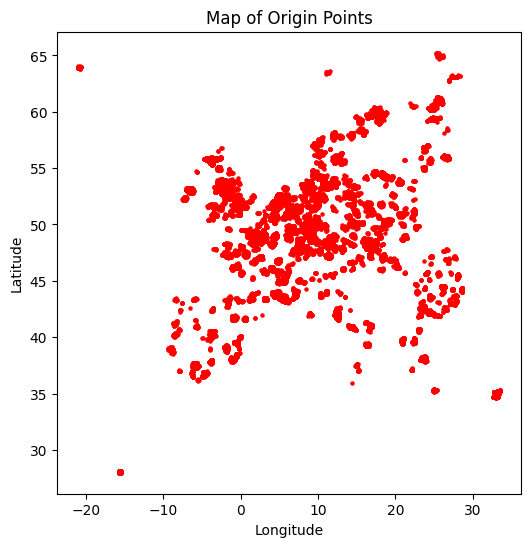

In [12]:
# Convert the coordinates to the appropriate coordinate system
gdf = gpd.GeoDataFrame(geometry=[Point(lat, lon) for lon, lat in origins], crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(ax=ax, marker='o', color='red', markersize=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Map of Origin Points')
plt.show()

...before displaying them on a world map. This allows us to check exemplary images and the correctness of all coordinate transformations.

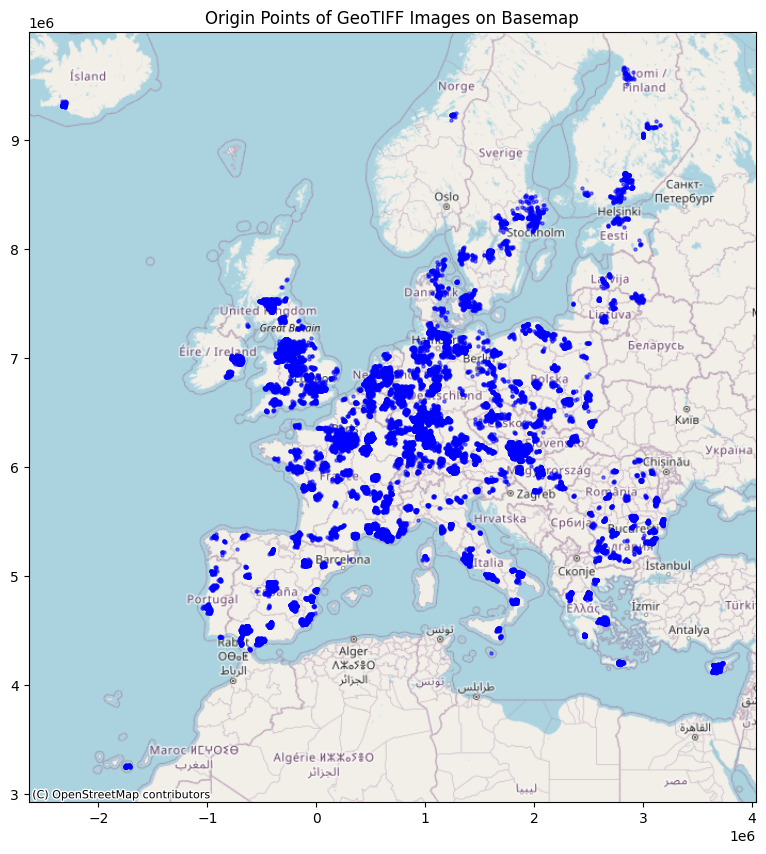

In [13]:
# Convert to Web Mercator for contextily
gdf_mercator = gdf.to_crs(epsg=3857)

# Padding for better visualization
padding_factor=0.05
total_bounds = gdf_mercator.total_bounds
x_range = total_bounds[2] - total_bounds[0]
y_range = total_bounds[3] - total_bounds[1]
padding_x = x_range * padding_factor
padding_y = y_range * padding_factor

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf_mercator.plot(ax=ax, color='blue', marker='o', markersize=5, alpha=0.5) # Add all points
ax.set_xlim([total_bounds[0] - padding_x, total_bounds[2] + padding_x])
ax.set_ylim([total_bounds[1] - padding_y, total_bounds[3] + padding_y])
ctx.add_basemap(ax, crs=gdf_mercator.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik) # Add basemap
ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
ax.set_title("Origin Points of GeoTIFF Images on Basemap")
plt.show()

# Introducing Major TOM

### No, not this one...

In [14]:
%%html
<iframe width="800" height="500" src="https://www.youtube.com/embed/KQRaj1vcnrs?si=qs6f2IhWNiw7yrb2"></iframe>

## ESA Φ-lab's Terrestrial Observation Metaset

ESA Φ-lab has launched Major TOM (Terrestrial Observation Metaset), a community-oriented project that allows researchers to share, use and combine large Earth observation (EO) datasets. Major TOM’s inaugural core dataset constitutes the largest ML-ready collection of Copernicus Sentinel-2 images (levels 1C and 2A) ever published.

### Setup

We can directly install Major TOM via pip and import the library.

In [15]:
!pip install -q leafmap datasets git+https://github.com/ESA-PhiLab/Major-TOM.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.4 MB/s eta 0:00:00


In [16]:
from pathlib import Path
import urllib.request
from majortom import *

### Explore data

We now explore the data that is provided to us by Major TOM. We use the same code twice: once for level 1C and once for level 2A.

In [17]:
SOURCE_DATASET = 'Major-TOM/Core-S2L2A'
DATASET_DIR = Path(os.path.expanduser('~/Major-TOM/L2A/'))
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}.parquet'.format(ACCESS_URL.split('.parquet')[0].split('/')[-1])

# Get all metadata for the specified data set
gdf_L2A = metadata_from_url(ACCESS_URL, LOCAL_URL)

In [18]:
SOURCE_DATASET = 'Major-TOM/Core-S2L1C'
DATASET_DIR = Path(os.path.expanduser('~/Major-TOM/L1C/'))
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}.parquet'.format(ACCESS_URL.split('.parquet')[0].split('/')[-1])

# Get all metadata for the specified data set
gdf_L1C = metadata_from_url(ACCESS_URL, LOCAL_URL)

We do now filter out all data that:
* has clouds or
* has missing data or
* does not appear on both levels under the specifications above.

In [19]:
filtered_df_L2A = filter_metadata(gdf_L2A,
                                cloud_cover = (0,0), # cloud cover between 0% and 0%
                                nodata=(0.0,0.0) # only 0% of no data allowed
                                )
filtered_df_L1C = filter_metadata(gdf_L1C,
                                cloud_cover = (0,0), # cloud cover between 0% and 0%
                                nodata=(0.0,0.0) # only 0% of no data allowed
                                )

# Only keep data present in both filtered data sets
set_L2A = set(filtered_df_L2A['grid_cell'])
set_L1C = set(filtered_df_L1C['grid_cell'])
common_grid_cells = set_L2A & set_L1C
filtered_df_L2A = filtered_df_L2A[filtered_df_L2A['grid_cell'].isin(common_grid_cells)]
filtered_df_L1C = filtered_df_L1C[filtered_df_L1C['grid_cell'].isin(common_grid_cells)]

Based on the filtered data from before, we then look for the Major TOM image that contains the specified coordinate (for all coordinates that we extracted before). We also consider that we only want the newest version of each grid cell.

In [20]:
from majortom.grid import Grid

MT_grid = Grid(10) # default Major TOM grid is 10km
query_df = pd.DataFrame(origins, columns=['Latitude', 'Longitude'])

# Check which grid cell contains a specific point (given in latitude, longitude)
rows,cols = MT_grid.latlon2rowcol(query_df.Latitude.tolist(),
                                  query_df.Longitude.tolist())
points = ['{}_{}'.format(i,j) for i, j in zip(rows,cols)]
query_df['grid_cell'] = points

# Keep only the newest version of each grid cell
filtered_L2A = filtered_df_L2A[filtered_df_L2A.grid_cell.isin(points)]
latest_index_L2A = filtered_L2A.groupby("grid_cell")["timestamp"].idxmax()
filtered_L2A = filtered_L2A.loc[latest_index_L2A]
filtered_L2A = filtered_L2A.sort_index()

# Keep only the newest version of each grid cell
filtered_L1C = filtered_df_L1C[filtered_df_L1C.grid_cell.isin(points)]
latest_index_L1C = filtered_L1C.groupby("grid_cell")["timestamp"].idxmax()
filtered_L1C = filtered_L1C.loc[latest_index_L1C]
filtered_L1C = filtered_L1C.sort_index()

Let's take a look at an exemplary image:

On level 1C...

grid_cell                                              312U_155L
grid_row_u                                                   312
grid_col_r                                                  -155
product_id     S2A_MSIL1C_20170401T115211_N0204_R123_T28RDS_2...
timestamp                                    2017-04-01 11:52:11
cloud_cover                                                  0.0
nodata                                                       0.0
centre_lat                                             28.069361
centre_lon                                            -15.721063
crs                                                   EPSG:32628
parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
parquet_row                                                  360
geometry            POINT (-15.72106332760161 28.06936087049198)
Name: 1319792, dtype: object


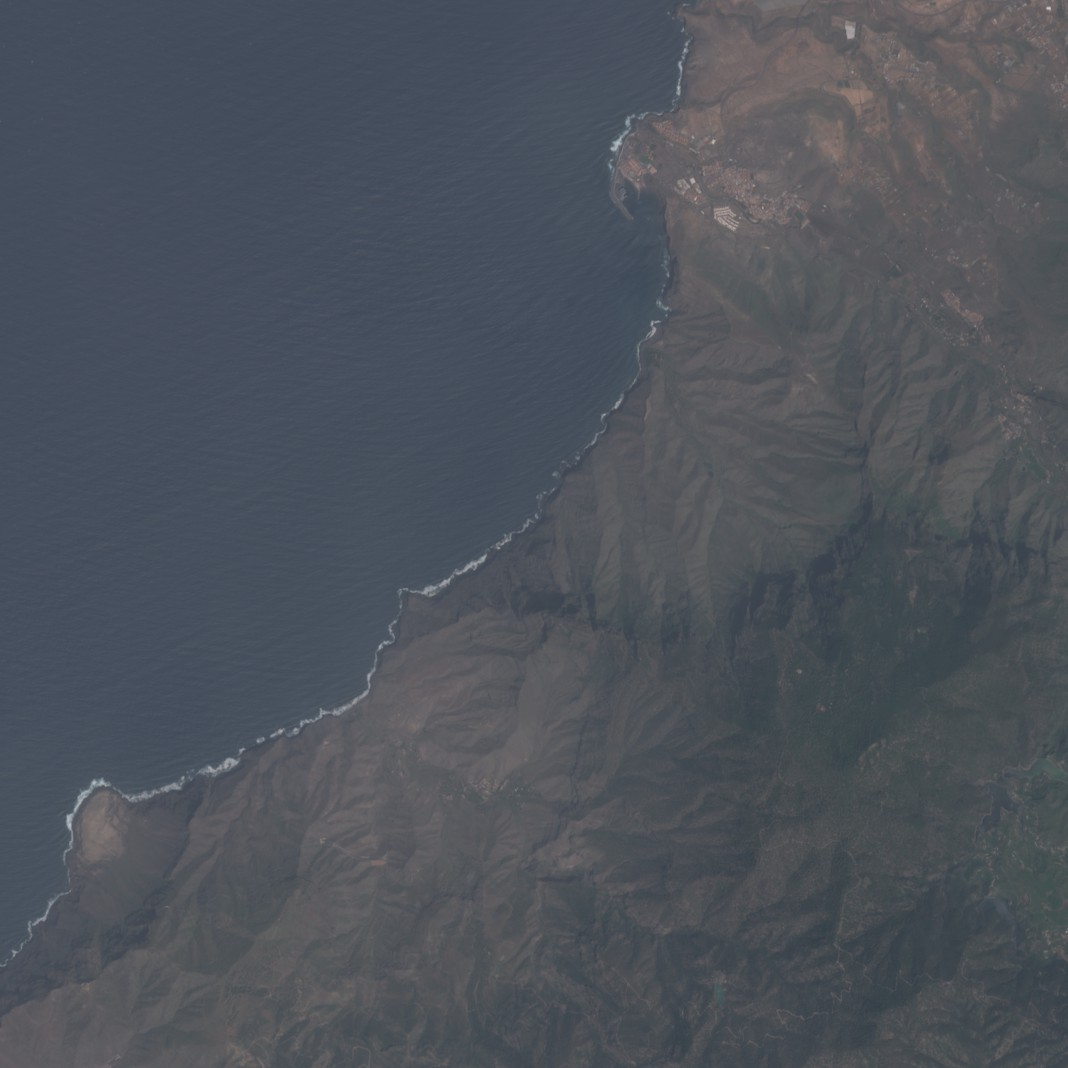

In [21]:
sample_1C = filtered_L1C.iloc[0]

out_1C = read_row(sample_1C,
               columns=["thumbnail"])

print(sample_1C)
out_1C

...and on level 2A.

grid_cell                                              312U_155L
grid_row_u                                                   312
grid_col_r                                                  -155
product_id     S2A_MSIL2A_20170401T115211_N0204_R123_T28RDS_2...
timestamp                                    2017-04-01 11:52:11
cloud_cover                                                  0.0
nodata                                                       0.0
centre_lat                                             28.069361
centre_lon                                            -15.721063
crs                                                   EPSG:32628
parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
parquet_row                                                  360
geometry            POINT (-15.72106332760161 28.06936087049198)
Name: 1319792, dtype: object


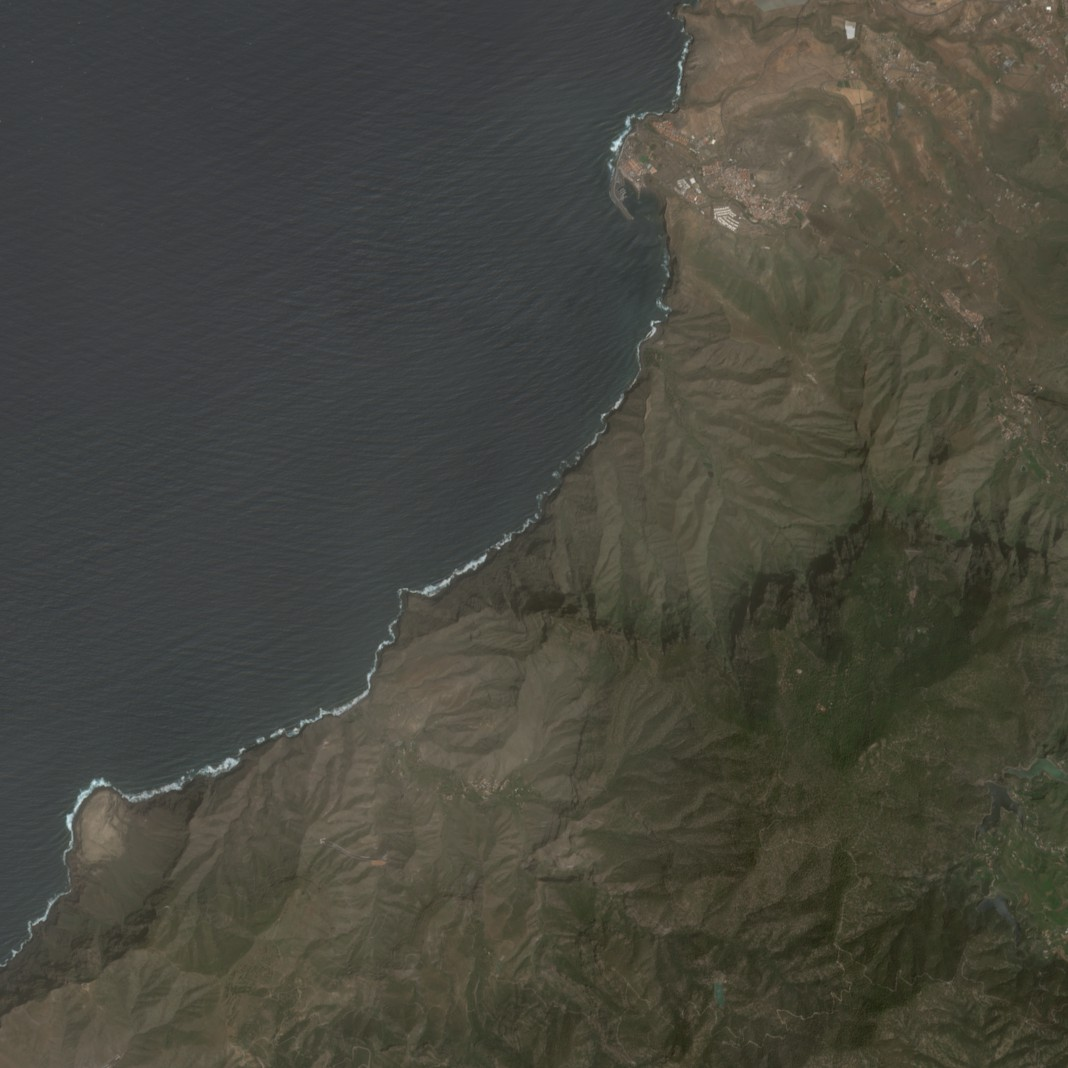

In [22]:
sample_2A = filtered_L2A.iloc[0]

out_2A = read_row(sample_2A,
               columns=["thumbnail"])

print(sample_2A)
out_2A

We note, that they have some differences in the coloring. Let's inspect that in more detail and compare specific patches from our training data to their Major TOM equivalents. The specifications for these comparisons where found manually by scrolling around maps, calculating coordinates and cropping the images based on visual inspection.

In [23]:
from PIL import Image

Let's take a look at an exemplary residential image.

Original training image


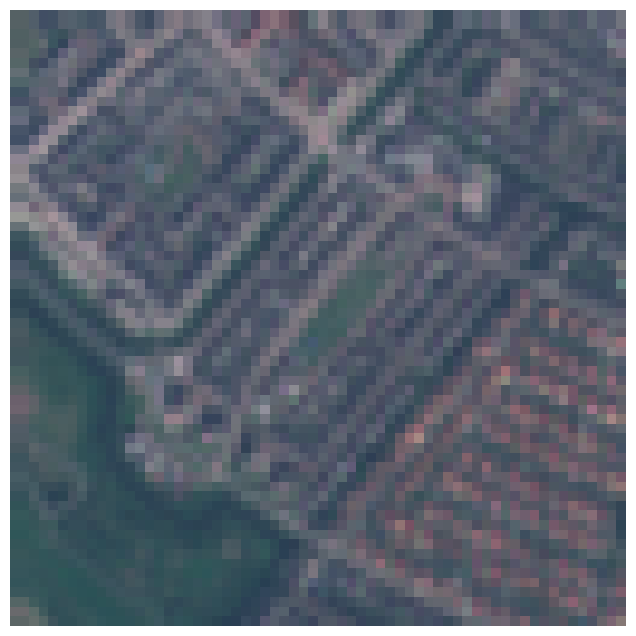

In [24]:
img_path = "/root/trainingdataMS/EuroSAT_MS/Residential/Residential_1.tif"

# Get RGB bands
with rasterio.open(img_path) as src:
    bands = src.read((4, 3, 2))
    bands = bands.transpose([1, 2, 0])

print("Original training image")

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

grid_cell                                               580U_31R
grid_row_u                                                   580
grid_col_r                                                    31
product_id     S2A_MSIL1C_20230614T105031_N0509_R051_T31UFT_2...
timestamp                                    2023-06-14 10:50:31
cloud_cover                                                  0.0
nodata                                                       0.0
centre_lat                                             52.139773
centre_lon                                              4.607476
crs                                                   EPSG:32631
parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
parquet_row                                                   35
geometry             POINT (4.607476419784341 52.13977314550232)
Name: 1825438, dtype: object

Major TOM level 1C equivalent


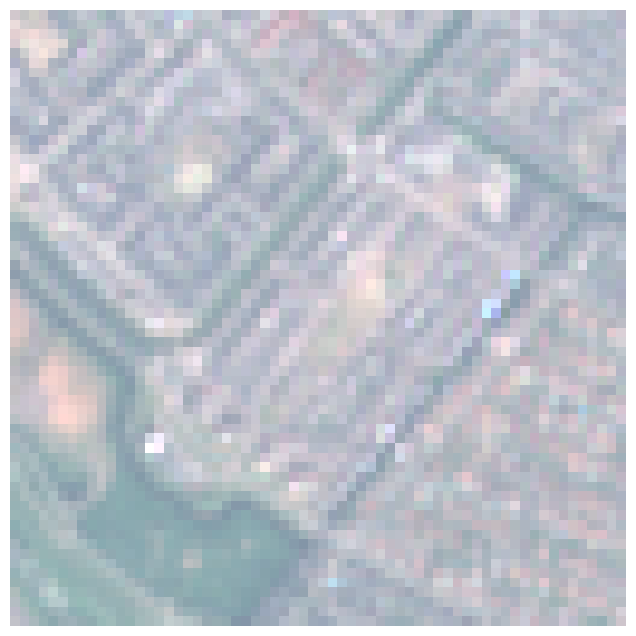

In [25]:
sample_1C = filtered_L1C[filtered_L1C["grid_cell"] == "580U_31R"].iloc[0]
out_1C = read_row(sample_1C,
               columns=["B04", "B03", "B02"])

print(sample_1C)
print()
print("Major TOM level 1C equivalent")

# Get RGB bands
bands = np.stack([out_1C["B04"], out_1C["B03"], out_1C["B02"]], axis=-1)
bands = bands[745:809, 740:804]

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

We can see that the colors are off. This is because baseline 0.4 introduced an offset value to encode more dark pixels. To get comparable images, we need to revert that offset. Then the images look similar again.

Major TOM level 1C equivalent with offset correction


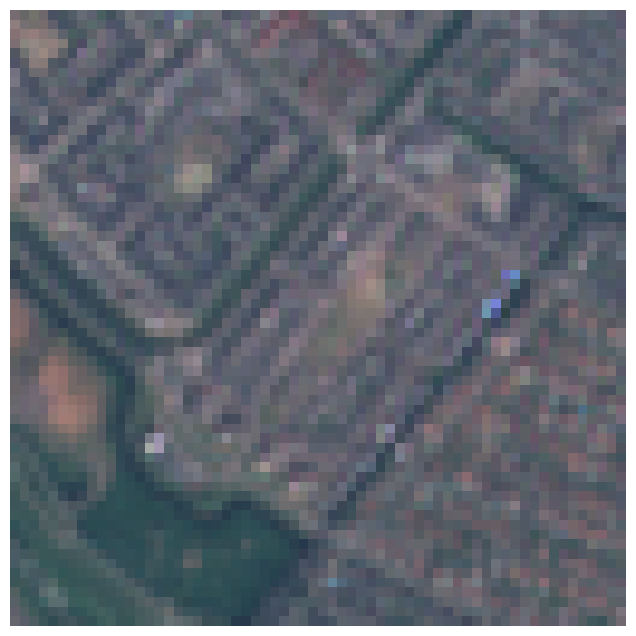

In [26]:
print("Major TOM level 1C equivalent with offset correction")

# Get RGB bands
bands = np.stack([out_1C["B04"], out_1C["B03"], out_1C["B02"]], axis=-1)
bands = np.clip(bands, 1000, None) # First clip the bands, to prevent variable underflows
bands -= 1000 # Revert the offset
bands = bands[745:809, 740:804]

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

Let's take a look at another exemplary residential image. This time, the image comes from an old processing baseline (i.e., no offset).

Original training image


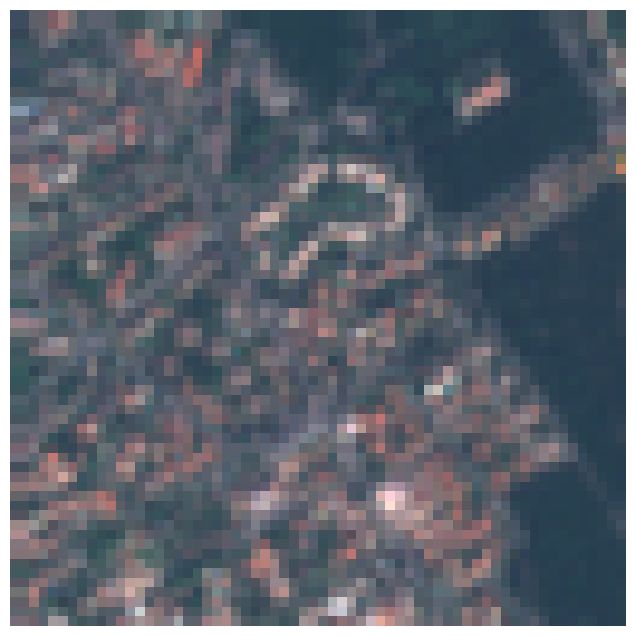

In [27]:
img_path = "/root/trainingdataMS/EuroSAT_MS/Residential/Residential_1600.tif"

# Get RGB bands
with rasterio.open(img_path) as src:
    bands = src.read((4, 3, 2))
    bands = bands.transpose([1, 2, 0])

print("Original training image")

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

grid_cell                                              465U_101R
grid_row_u                                                   465
grid_col_r                                                   101
product_id     S2B_MSIL1C_20180421T100029_N0206_R122_T33TTG_2...
timestamp                                    2018-04-21 10:00:29
cloud_cover                                                  0.0
nodata                                                       0.0
centre_lat                                             41.812919
centre_lon                                             12.218672
crs                                                   EPSG:32633
parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
parquet_row                                                   40
geometry            POINT (12.218672281945404 41.81291926563044)
Name: 1613958, dtype: object

Major TOM level 1C equivalent


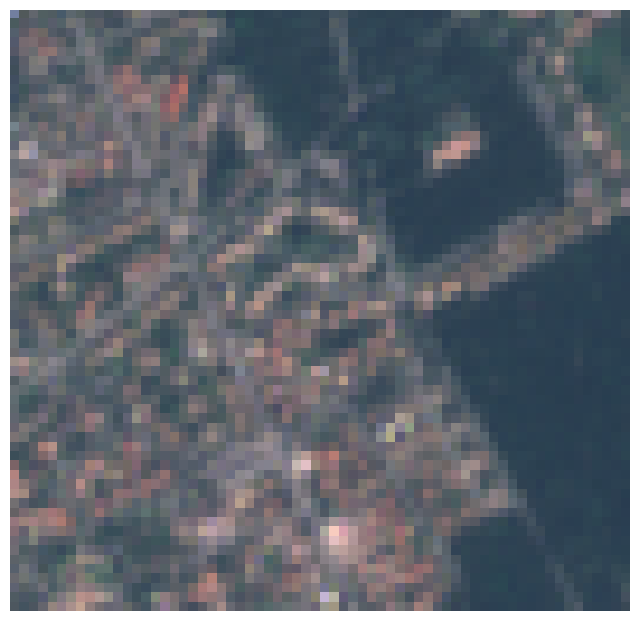

In [28]:
sample_1C = filtered_L1C[filtered_L1C["grid_cell"] == "465U_101R"].iloc[0]
out_1C = read_row(sample_1C,
               columns=["B04", "B03", "B02"])

print(sample_1C)
print()
print("Major TOM level 1C equivalent")

# Get RGB bands
bands = np.stack([out_1C["B04"], out_1C["B03"], out_1C["B02"]], axis=-1)
bands = bands[172:236, 430:496]

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

So far we only looked at level 1C. Let's look at level 2A for the last image.

grid_cell                                              465U_101R
grid_row_u                                                   465
grid_col_r                                                   101
product_id     S2B_MSIL2A_20180421T100029_N0207_R122_T33TTG_2...
timestamp                                    2018-04-21 10:00:29
cloud_cover                                                  0.0
nodata                                                       0.0
centre_lat                                             41.812919
centre_lon                                             12.218672
crs                                                   EPSG:32633
parquet_url    https://huggingface.co/datasets/Major-TOM/Core...
parquet_row                                                   40
geometry            POINT (12.218672281945404 41.81291926563044)
Name: 1613958, dtype: object

Major TOM level 2A


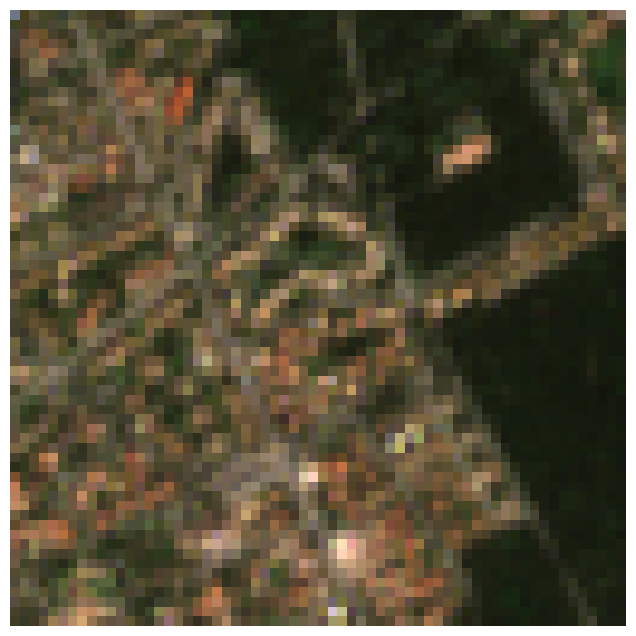

In [29]:
sample_2A = filtered_L2A[filtered_L2A["grid_cell"] == "465U_101R"].iloc[0]
out_2A = read_row(sample_2A,
               columns=["B04", "B03", "B02"])

print(sample_2A)
print()
print("Major TOM level 2A")

# Get RGB bands
bands = np.stack([out_2A["B04"], out_2A["B03"], out_2A["B02"]], axis=-1)
bands = bands[172:236, 430:494]

# Scale to appropriate color space
img_scaled = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(img_scaled)
plt.axis('off')
plt.show()

### Create AB Dataset

In the previous examples we have seen that there is a difference between the level 1C and the level 2A images. We now want to create paired images that contain the exact same image depicted on both levels (we call this AB, with A being the L1C and B being the L2A image).

In this process we create the folder:
* dataMajTOM_MS

Each 1068x1068 Major TOM image that we have (~3'600 images) can be cut up into 256 smaller 64x64 patches. Thus, we fill the folder with multiple MajTOM_test_*.zip and MajTOM_train_*.zip files, each containing the patches from 500 Major TOM images.

In [30]:
import cv2
import re
import random
random.seed(0)

if not os.path.exists(os.path.expanduser("~/MajTOM")):
    os.makedirs(os.path.expanduser("~/MajTOM"))
    os.makedirs(os.path.expanduser("~/MajTOM/train"))
    os.makedirs(os.path.expanduser("~/MajTOM/test"))

In [31]:
if not os.path.exists(os.path.expanduser("./dataMajTOM_MS")):

  total_count = 0
  zip_count = 0

  for df_indx in range(len(filtered_L1C)):
    print(df_indx)

    # Get the image, find the baseline in the metadata and extract bands 2, 3, 4 & 8 accordingly
    L1C_entry = filtered_L1C.iloc[df_indx]
    L1C_entry_pid = L1C_entry["product_id"]
    L1C_entry_match = re.search(r'N(\d{4})', L1C_entry_pid)
    L1C_entry_baseline = L1C_entry_match.group(1)
    L1C_old_baselines = ['0201', '0202', '0204', '0205', '0206', '0207', '0208', '0300', '0301']
    L1C_new_baselines = ['0400', '0500', '0510', '0509']
    out_L1C = read_row(L1C_entry, columns=["B02", "B03", "B04", "B08"])
    # if newer baseline (0.4+), we revert the offset
    if L1C_entry_baseline in L1C_new_baselines:
      bands_L1C = np.stack([out_L1C["B02"], out_L1C["B03"], out_L1C["B04"], out_L1C["B08"]], axis=-1)
      bands_L1C_clipped = np.clip(bands_L1C, 1000, None)
      bands_L1C = bands_L1C_clipped - 1000
    # else we don't need to consider the offset
    elif L1C_entry_baseline in L1C_old_baselines:
      bands_L1C = np.stack([out_L1C["B02"], out_L1C["B03"], out_L1C["B04"], out_L1C["B08"]], axis=-1)
    # failsafe
    else:
      raise Error

    # Get the image, find the baseline in the metadata and extract bands 2, 3, 4 & 8 accordingly
    L2A_entry = filtered_L2A.iloc[df_indx]
    L2A_entry_pid = L2A_entry["product_id"]
    L2A_entry_match = re.search(r'N(\d{4})', L2A_entry_pid)
    L2A_entry_baseline = L2A_entry_match.group(1)
    L2A_old_baselines = ['0201', '0204', '0205', '0206', '0207', '0208', '0209', '0210', '0211', '0212', '0213', '0214', '0300', '0301']
    L2A_new_baselines = ['0400', '0500', '0509', '0510', '9999']
    out_L2A = read_row(L2A_entry, columns=["B02", "B03", "B04", "B08"])
    # if newer baseline (0.4+), we revert the offset
    if L2A_entry_baseline in L2A_new_baselines:
      bands_L2A = np.stack([out_L2A["B02"], out_L2A["B03"], out_L2A["B04"], out_L2A["B08"]], axis=-1)
      bands_L2A_clipped = np.clip(bands_L2A, 1000, None)
      bands_L2A = bands_L2A_clipped - 1000
    # else we don't need to consider the offset
    elif L2A_entry_baseline in L2A_old_baselines:
      bands_L2A = np.stack([out_L2A["B02"], out_L2A["B03"], out_L2A["B04"], out_L2A["B08"]], axis=-1)
    # failsafe
    else:
      raise Error

    # We can create 16 rows / columns, and a margin of 2 in between
    current_row = 0
    for r in range(16):
      current_col = 0
      # For each patch, we cut the data and store it as .npy file
      for c in range(16):
        bands_L1C_patch = bands_L1C[current_row:current_row+64, current_col:current_col+64]
        img_L1C = bands_L1C_patch

        bands_L2A_patch = bands_L2A[current_row:current_row+64, current_col:current_col+64]
        img_L2A = bands_L2A_patch

        name_AB = f"image_{total_count}.npy"
        total_count += 1

        # we separate the data to keep some for training
        if random.random() < 0.9:
          path_AB = os.path.join(os.path.expanduser("~/MajTOM/train"), name_AB)
        else:
          path_AB = os.path.join(os.path.expanduser("~/MajTOM/test"), name_AB)

        # The final AB product contains the A (L1C) data on the left side and B (L2A) on the right
        img_AB = np.concatenate([img_L1C, img_L2A], 1)

        np.save(path_AB, img_AB)

        current_col += 66

      current_row += 66

    if df_indx>0 and (df_indx%500==0 or df_indx==len(filtered_L1C)-1):
      # zip the whole folders:
      zip_name_train = f"MajTOM_train_{zip_count}.zip"
      !zip -r ~/MajTOM/{zip_name_train} ~/MajTOM/train
      zip_name_test = f"MajTOM_test_{zip_count}.zip"
      !zip -r ~/MajTOM/{zip_name_test} ~/MajTOM/test
      zip_count += 1

      # move the zipped folders to ./dataMajTOM
      if not os.path.exists(os.path.expanduser("./dataMajTOM_MS")):
        os.makedirs(os.path.expanduser("./dataMajTOM_MS"))
      !mv ~/MajTOM/{zip_name_train} ./dataMajTOM_MS/
      !mv ~/MajTOM/{zip_name_test} ./dataMajTOM_MS/

      # remove all to manage memory
      !rm -rf ~/MajTOM
      # add the folders again (if necessary)
      if df_indx%500==0:
        os.makedirs(os.path.expanduser("~/MajTOM"))
        os.makedirs(os.path.expanduser("~/MajTOM/train"))
        os.makedirs(os.path.expanduser("~/MajTOM/test"))
else:
    print("No need to create AB Data again.")

No need to create AB Data again.


# Prepare own AB Data

Finally, we prepare our original training and testing data in the exact same AB format as described above, such that we can use them in our model.

In this process we create the folder:
* dataAB_MS

It contains the two zip files DataAB_train.zip and DataAB_test.zip.    



In [32]:
if not os.path.exists(os.path.expanduser("~/dataAB")):
    os.makedirs(os.path.expanduser("~/dataAB"))
    os.makedirs(os.path.expanduser("~/dataAB/train_transformed"))
    os.makedirs(os.path.expanduser("~/dataAB/test_transformed"))

In [33]:
if not os.path.exists(os.path.expanduser("./dataAB_MS")):

  # Define all training images
  training_label_path_map = pd.read_csv(os.path.expanduser("~/trainingdataMS/EuroSAT_MS/train.csv"))
  path_map = training_label_path_map["path"]
  base_dir = os.path.expanduser("~/trainingdataMS/EuroSAT_MS")
  full_path_map = path_map.apply(lambda x: os.path.join(base_dir, x)).reset_index(drop=True)

  # Define all testing images
  prediction_dir = os.path.expanduser("~/testset/testset")
  pred_paths = [(int(x.split("_")[-1].split(".")[0]), x) for x in os.listdir(prediction_dir)]
  df = pd.DataFrame(pred_paths, columns=["i", "path"])
  df_sorted = df.sort_values(by="i")
  prediction_paths = df_sorted["path"]
  full_prediction_paths = prediction_paths.apply(lambda x: os.path.join(prediction_dir, x)).reset_index(drop=True)

  # Define an empty (black) image
  black_image = np.zeros((64, 64, 4), dtype=np.uint16)

  # We store each training image as a Training-BlackImage (AB) numpy array
  for image in full_path_map:
    image_name = image.split("/")[-1][:-4]
    # Load channels 2, 3, 4 & 8
    with rasterio.open(image) as src:
      bands = src.read((2, 3, 4, 8))
    bands = bands.transpose([1, 2, 0])
    img = bands
    img_AB = np.concatenate([img, black_image], 1) # L1C left
    name_AB = f"{image_name}.npy"
    path_AB = os.path.join(os.path.expanduser("~/dataAB/train_transformed"), name_AB)
    np.save(path_AB, img_AB)

  # We store each testing image as a BlackImage-Testing (AB) numpy array
  for image in full_prediction_paths:
    image_name = image.split("/")[-1][:-4]
    # Load channels 2, 3, 4 & 8
    img = np.load(image)
    bands = img[:, :, [1, 2, 3, 7]]
    img = bands
    img_AB = np.concatenate([black_image, img], 1) # L2A right
    name_AB = f"{image_name}.npy"
    path_AB = os.path.join(os.path.expanduser("~/dataAB/test_transformed"), name_AB)
    np.save(path_AB, img_AB)

  # Create the Google Drive folder
  if not os.path.exists(os.path.expanduser("./dataAB_MS")):
    os.makedirs(os.path.expanduser("./dataAB_MS"))

  # Store the zip files on Google Drive
  zip_name = f"DataAB_train.zip"
  !zip -r ~/dataAB/{zip_name} ~/dataAB/train_transformed
  !mv ~/dataAB/{zip_name} ./dataAB_MS/
  zip_name = f"DataAB_test.zip"
  !zip -r ~/dataAB/{zip_name} ~/dataAB/test_transformed
  !mv ~/dataAB/{zip_name} ./dataAB_MS/

else:
    print("No need to create AB Data again.")

No need to create AB Data again.


Now we have our data prepared for model training. Please open the second notebook.